## Conclusions and Visualizations

In this notebook we make conclusions from the numerical results of the experiments. We will also make some visualizations to help us understand the results better.

Contents:

- plot 1: x: min gain - max gain, y: fraction of pairs with gain smaller than x

- plot 2: average variance over all pairs over time

- average cycle length
 
- plot 3

In [128]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re


In [129]:
sym_file = "so_sioux.out"
analytical_file = "xD.out"
with open(sym_file) as f:
    global data
    
    lines = f.readlines()

    # filter out pairs that were not simulated    
    data = [line for line in lines if not line.startswith("Not enough routes ")]

with open(analytical_file) as f:
    global analytical_data
    
    lines = f.readlines()

    # filter out pairs that were not simulated    
    analytical_data = [line for line in lines if not line.startswith("Not enough routes ")]

# create a pandas dataframe to store the data
data_dict = {}

# iterate over the lines - each od pair starts with a "Running simulation for" line
for i, line in enumerate(data):
    
    if not line.startswith("Running simulation for"):
        continue
        
    # get the origin and destination
    origin = line.split()[-2]
    destination = line.split()[-1]
    
    data_dict[(origin, destination)] = {}
    
    conv_line = data[i+1]
    data_dict[(origin, destination)]["convergence"] = -1
    if conv_line.startswith("Converged in"):
        # get the number of iterations
        data_dict[(origin, destination)]["convergence"] = int(conv_line.split()[-2])

    diff_line = data[i+2]
    data_dict[(origin, destination)]["difference"] = float(diff_line.split()[-2])
    data_dict[((origin, destination))]["UE_time"] = float(diff_line.split()[-1])
    
    mean_line = data[i+3]
    # array of mean values (floats)
    match = re.findall(r"[-+]?\d*\.\d+(?:[eE][-+]?\d+)?|[-+]?\d+(?:[eE][-+]?\d+)?", mean_line)

    
    if match:
        data_dict[(origin, destination)]["mean"] = [float(x) for x in match]
    else:
        data_dict[(origin, destination)]["mean"] = []
                
    variance_line = data[i+4]
    # array of variance values (floats)
    match = re.findall(r"[-+]?\d*\.\d+(?:[eE][-+]?\d+)?|[-+]?\d+(?:[eE][-+]?\d+)?", variance_line)

    
    if match:
        data_dict[(origin, destination)]["variance"] = [float(x) for x in match]
    else:
        data_dict[(origin, destination)]["variance"] = []
        
    hist_line = data[i+5]
    # array of arrays of integers
    match = re.search(r"\[\[([0-9.,\s\[\]]+)\]\]", hist_line)
    
    if match:
        data_dict[(origin, destination)]["history"] = [list(map(int, x.split(",")) ) for x in match.group(1).split("], [")]
    else:
        data_dict[(origin, destination)]["history"] = []
    
    # get number of agents
    agents_line = data[i+6]
    data_dict[(origin, destination)]["agents"] = round(float(agents_line.split()[-1]))

    # get inequity
    inequity_line = data[i+7]
    
    match =re.findall(r"[-+]?\d*\.\d+(?:[eE][-+]?\d+)?|[-+]?\d+(?:[eE][-+]?\d+)?", inequity_line)
    
    if match:
        data_dict[(origin, destination)]["inequity"] = [float(x) for x in match]
    else:
        data_dict[(origin, destination)]["inequity"] = []
        
    # get almost convergence
    almost_conv_line = data[i+8]

    # match that finds the array of integers, separated by commas and possibly negative
    match = re.search(r"\[([0-9,\s-]+)\]", almost_conv_line)
    
    if match:
        data_dict[(origin, destination)]["almost_convergence"] = list(map(int, match.group(1).split(",")))
    else:
        data_dict[(origin, destination)]["almost_convergence"] = []
        
    # get the standarized inequity
    
    standarized_inequity_line = data[i+9]
    
    match =re.findall(r"[-+]?\d*\.\d+(?:[eE][-+]?\d+)?|[-+]?\d+(?:[eE][-+]?\d+)?", standarized_inequity_line)
    
    if match:
        data_dict[(origin, destination)]["inequity_norm"] = [float(x) for x in match]
    else:
        data_dict[(origin, destination)]["inequity_norm"] = []
        
    data_dict[(origin, destination)]["min_inequity"] = min(data_dict[(origin, destination)]["inequity_norm"])
        
    data_dict[(origin, destination)]["min_inequity_at_5"] = min(data_dict[(origin, destination)]["inequity_norm"][:5])
    
    data_dict[(origin, destination)]["min_inequity_at_10"] = min(data_dict[(origin, destination)]["inequity_norm"][:10])
    
    data_dict[(origin, destination)]["min_inequity_at_20"] = min(data_dict[(origin, destination)]["inequity_norm"][:20])
# add the analytical data

for i, line in enumerate(analytical_data):
    if not line.startswith("OD pair"):
        continue
    origin, destination = line.split()[-1].split("-")
    
    next_line = analytical_data[i+1]
    data_dict[(origin, destination)]["analytical"] = int(next_line.split()[-1])
    
    next_line = analytical_data[i+2]
    data_dict[(origin, destination)]["gcd_analytical"] = int(next_line.split()[-1])
    

In [130]:
# use the data_dict to create a pandas dataframe
df = pd.DataFrame(data_dict).T
# add a column for the OD pair
df["OD"] = df.index
df["OD"] = df["OD"].apply(lambda x: " -> ".join(x))

#

In [131]:
# basic statistics
# number of converged pairs
print(f"Number of pairs: {len(df)}")
converged = df[df["convergence"] != -1]
not_converged = df[df["convergence"] == -1]
print(f"Converged: {len(converged)}")
print(f"Not converged: {len(not_converged)}")

Number of pairs: 188
Converged: 69
Not converged: 119


In [132]:
# number of cases where convergence is equal to analytical
print("Convergence equal to analytical: ", len(df[df["convergence"] == df["analytical"]]))
# number of cases where convergence is equal to gcd analytical and smaller than analytical
print("Convergence equal to gcd analytical while opting works: ", (len(df[df["convergence"] == df["gcd_analytical"]] )) - len(df[df["convergence"] == df["analytical"]]))
# number of cases where convergence is less than gcd analytical
print("Convergence less than gcd analytical: ", (len(df[df["convergence"] < df["gcd_analytical"]]) - len(df[df["convergence"] == -1])))
# number of cases where convergence is greater than analytical
print("Convergence greater than analytical: ", len(df[df["convergence"] > df["analytical"]]))

# reshape almost convergence to multiple columns
almost_conv_params = df["almost_convergence"].apply(len).max()
for i in range(almost_conv_params):
    df["almost_convergence_" + str(i)] = df["almost_convergence"].apply(lambda x: x[i] if i < len(x) else np.nan)
    
for i in range(almost_conv_params):
    print("Convergence greater than almost convergence "+ str(i) + ": " , len(df[df["convergence"] > df["almost_convergence_" + str(i)] ]))

Convergence equal to analytical:  11
Convergence equal to gcd analytical while opting works:  58
Convergence less than gcd analytical:  0
Convergence greater than analytical:  0
Convergence greater than almost convergence 0:  62
Convergence greater than almost convergence 1:  41
Convergence greater than almost convergence 2:  31


In [133]:
# stats for the analytical data
# mean, max, 95th percentile, 99th percentile of the analytical data
print("Max analytical: ", df["analytical"].max())
print("Mean analytical: ", df["analytical"].mean())
print("Median analytical: ", df["analytical"].median())
print("75th percentile analytical: ", df["analytical"].quantile(0.75))
print("95th percentile analytical: ", df["analytical"].quantile(0.95))
print("std analytical: ", df["analytical"].std())
# mean, max, 95th percentile, 99th percentile of the gcd analytical data
print("Max gcd analytical: ", df["gcd_analytical"].max())
print("Mean gcd analytical: ", df["gcd_analytical"].mean())
print("Median gcd analytical: ", df["gcd_analytical"].median())
print("75th percentile gcd analytical: ", df["gcd_analytical"].quantile(0.75))
print("95th percentile gcd analytical: ", df["gcd_analytical"].quantile(0.95))
print("std gcd analytical: ", df["gcd_analytical"].std())



# % of cycles shorter than 5, 10, 20 days
print("Percentage of cycles shorter than 5 days: ", len(df[df["analytical"] <= 5])/len(df))
print("Percentage of cycles shorter than 10 days: ", len(df[df["analytical"] <= 10])/len(df))
print("Percentage of cycles shorter than 20 days: ", len(df[df["analytical"] <= 20])/len(df))
# for gcd analytical
print("Percentage of cycles shorter than 5 days (gcd analytical): ", len(df[df["gcd_analytical"] <= 5])/len(df))
print("Percentage of cycles shorter than 10 days (gcd analytical): ", len(df[df["gcd_analytical"] <= 10])/len(df))
print("Percentage of cycles shorter than 20 days (gcd analytical): ", len(df[df["gcd_analytical"] <= 20])/len(df))
      


Max analytical:  2500
Mean analytical:  640.3457446808511
Median analytical:  500.0
75th percentile analytical:  800.0
95th percentile analytical:  1865.0000000000005
std analytical:  526.3922437307281
Max gcd analytical:  2500
Mean gcd analytical:  415.0
Median gcd analytical:  299.5
75th percentile gcd analytical:  599.0
95th percentile gcd analytical:  1400.0
std gcd analytical:  464.23950807273496
Percentage of cycles shorter than 5 days:  0.0
Percentage of cycles shorter than 10 days:  0.0
Percentage of cycles shorter than 20 days:  0.0
Percentage of cycles shorter than 5 days (gcd analytical):  0.015957446808510637
Percentage of cycles shorter than 10 days (gcd analytical):  0.015957446808510637
Percentage of cycles shorter than 20 days (gcd analytical):  0.05319148936170213


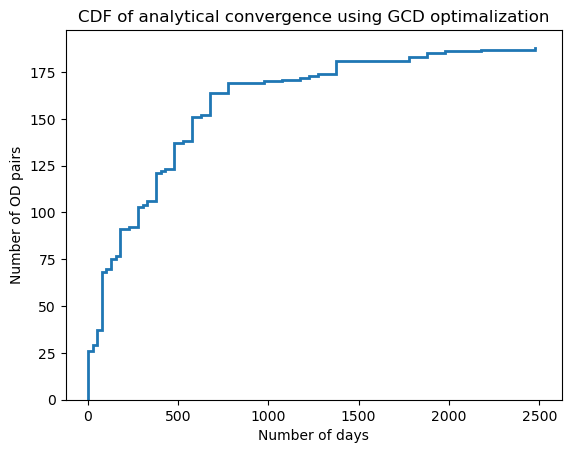

In [134]:
#cdf of the analytical convergence 
plt.figure()
# plt.hist(df["analytical"], bins=100, cumulative=True, histtype='step', label='Analytical', linewidth=2)
plt.hist(df["gcd_analytical"], bins=100, cumulative=True, histtype='step', label='GCD analytical', linewidth=2)
plt.title("CDF of analytical convergence using GCD optimalization")
plt.xlabel("Number of days")
plt.ylabel("Number of OD pairs")
last_bin = df["analytical"].max()
plt.axvline(x=last_bin, color='white', linewidth=3)
# get rid of the last tick
plt.show()


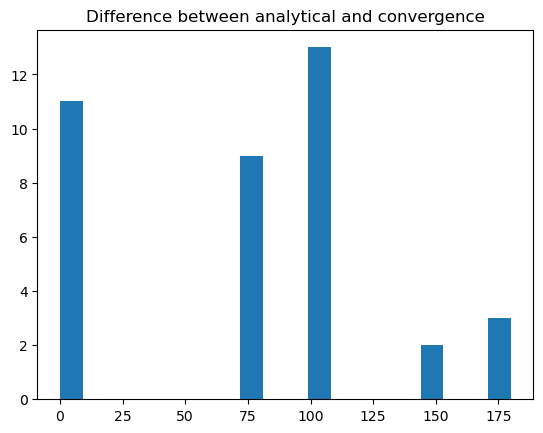

In [135]:
# plot results above as a difference histogram
conv_diff = df["analytical"] - df["convergence"]
# limit x to 200
conv_diff = conv_diff[conv_diff < 200]
plt.hist(conv_diff, bins=20)
plt.title("Difference between analytical and convergence")
plt.show()


16
61


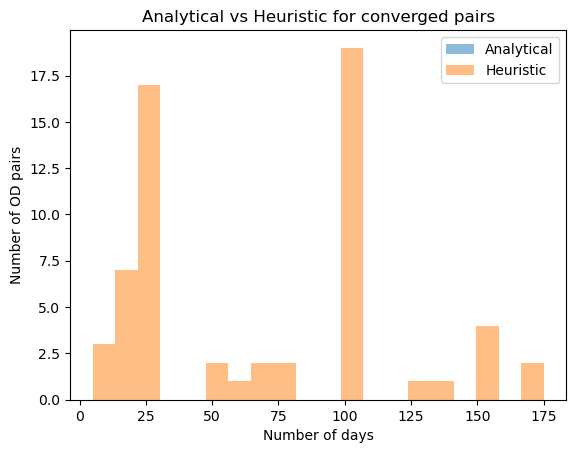

percentage of cases that are inclued in a plot above:  0.0851063829787234


In [136]:
# heuristic vs analytical approach
# histogram
dftmp = df[df["convergence"] != -1]
print(dftmp["analytical"][dftmp["analytical"] < 200].size)
print(dftmp["convergence"][dftmp["convergence"] < 200].size)
plt.figure()
plt.hist(dftmp["analytical"][dftmp["analytical"] < 200], bins=20, alpha=0.5, label="Analytical")
plt.hist(dftmp["convergence"][dftmp["convergence"] < 200], bins=20, alpha=0.5, label="Heuristic")
plt.legend(loc="upper right")
plt.title("Analytical vs Heuristic for converged pairs")
plt.xlabel("Number of days")
plt.ylabel("Number of OD pairs")
plt.show()


print("percentage of cases that are inclued in a plot above: ", dftmp["analytical"][dftmp["analytical"] < 200].size / df["analytical"].size)

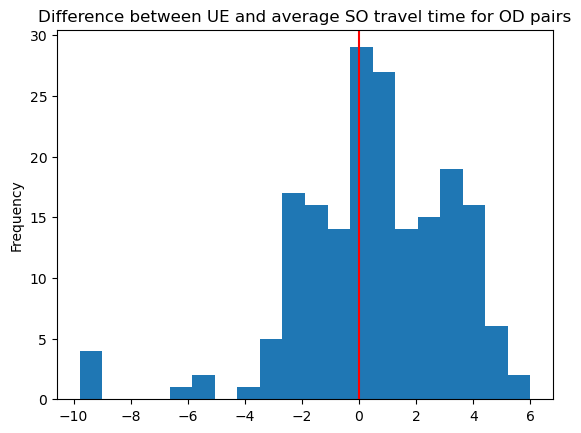

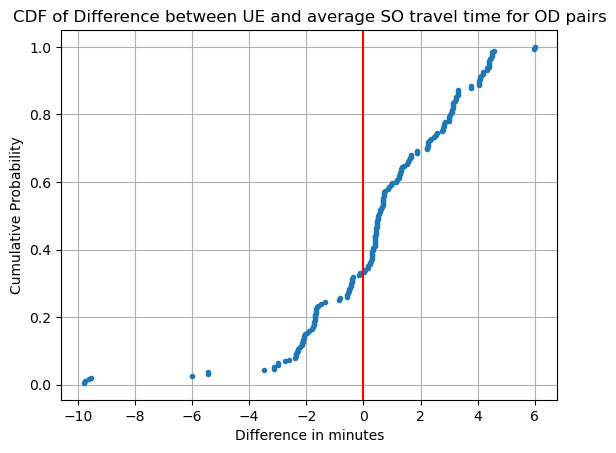

In [137]:
# create plots

# sort the df by the difference
df = df.sort_values(by="difference")

# create a histogram of the difference
plt.figure()
df["difference"].plot(kind="hist", bins=20)
# add line at 0
plt.axvline(x=0, color="red")
plt.title("Difference between UE and average SO travel time for OD pairs")
plt.show()
# mke it cdf plot

# Extract the data from the 'difference' column
sorted = df["difference"].sort_values()

# Calculate the cumulative distribution
cdf = np.arange(1, len(sorted) + 1) / len(sorted)

# Plot the CDF
plt.figure()
plt.plot(sorted, cdf, marker=".", linestyle="none")
plt.axvline(x=0, color="red")
# add units - x axis is in minutes
plt.xlabel("Difference in minutes")
plt.title("CDF of Difference between UE and average SO travel time for OD pairs")
plt.ylabel("Cumulative Probability")
plt.grid(True)
plt.show()

In [138]:
# print percentage of negative differences
print("Percentage of OD pairs with negative differences: ", (df["difference"] < 0).sum() / len(df) * 100, "%")
print("Percentage of OD pairs with positive differences: ", (df["difference"] > 0).sum() / len(df) * 100, "%")

Percentage of OD pairs with negative differences:  32.97872340425532 %
Percentage of OD pairs with positive differences:  67.02127659574468 %


In [139]:
# print 5 pairs with the highest difference
print("5 pairs with the highest difference: ")
print(df.head(5))


5 pairs with the highest difference: 
      convergence difference    UE_time  \
17 2           25  -9.787985  41.670015   
2  17         100  -9.766018  41.491682   
19 2           -1   -9.62061  42.754642   
2  19          -1  -9.554092  42.612108   
21 9          150    -6.0206  32.790733   

                                                    mean  \
17 2   [51.458, 102.916, 154.374, 205.832, 257.29, 30...   
2  17  [51.25769999999999, 102.51539999999999, 153.77...   
19 2   [52.37525252525253, 104.75050505050505, 157.12...   
2  19  [52.166199999999996, 104.33239999999999, 156.4...   
21 9   [38.81133333333333, 77.62266666666666, 116.433...   

                                                variance  \
17 2   [0.08601600000000093, 0.13926399999999903, 0.1...   
2  17  [0.09257571000000052, 0.14722884000000083, 0.1...   
19 2   [0.12407140087746081, 0.08641489643913851, 0.1...   
2  19  [0.13771955999999883, 0.08750224000000062, 0.1...   
21 9   [0.5128248888888886, 1.018766222222

In [140]:
df2 = df[df["convergence"] != -1].copy()
df3 = df[df["convergence"] == -1].copy()

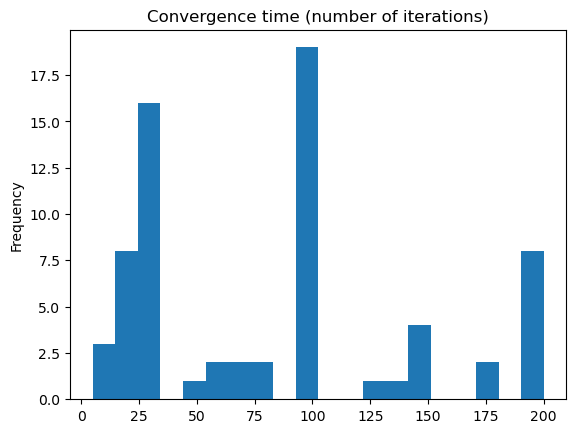

In [141]:
# lenght of the average cycle (convergence)
# filter out the pairs that did not converge
plt.figure()
df2["convergence"].plot(kind="hist", bins=20)
plt.title("Convergence time (number of iterations)")
plt.show()


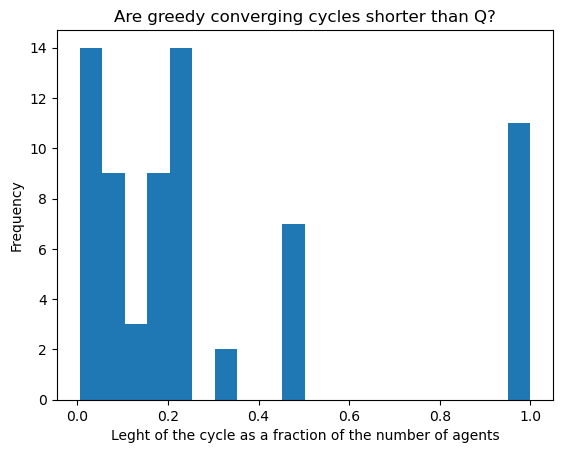

In [142]:
# convergence/agents
plt.figure()
(df2["convergence"] / df2["agents"]).plot(kind="hist", bins=20)
plt.title("Are greedy converging cycles shorter than Q?")
plt.xlabel("Leght of the cycle as a fraction of the number of agents")
plt.show()

# sort by this ratio and print head
df2["ratio"] = df2["convergence"] / df2["agents"]
df2 = df2.sort_values(by="ratio")
      

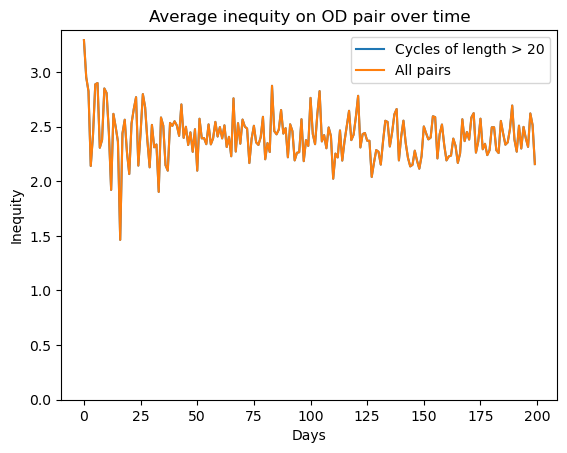

In [143]:
# plot average inequity for non-converging cycles with tolerance
avg_inequity = np.mean(df3['inequity'].to_list(), axis=0)
avg_inequity_all = np.mean(df['inequity'].to_list(), axis=0)
df4 = df[df["analytical"] > 20]
avg_inequity_analytical = np.mean(df4['inequity'].to_list(), axis=0)
plt.figure()
# plt.plot(avg_inequity)
plt.plot(avg_inequity_analytical)
plt.plot(avg_inequity_all)
plt.ylim(ymin=0)
plt.xlabel("Days")
plt.ylabel("Inequity")
plt.title("Average inequity on OD pair over time")
plt.legend(["Cycles of length > 20", "All pairs"])
plt.show()



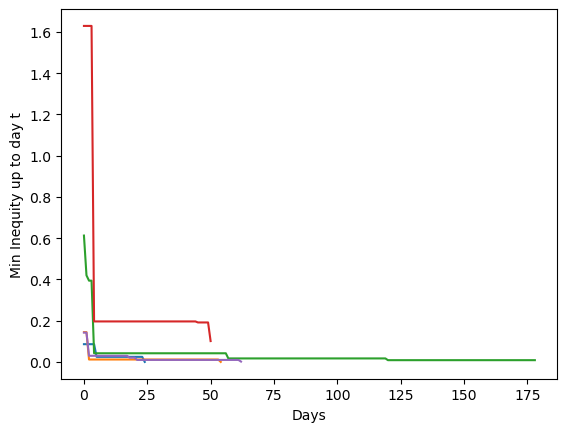

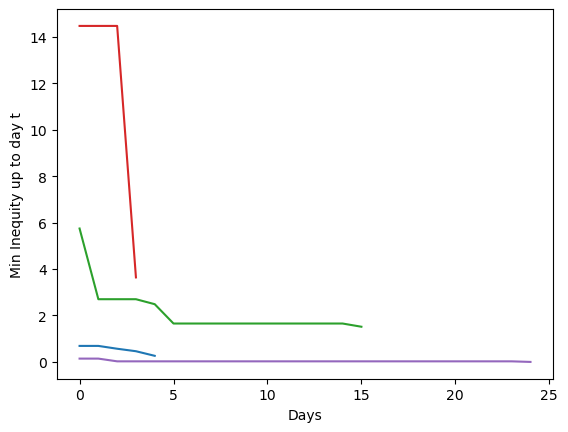

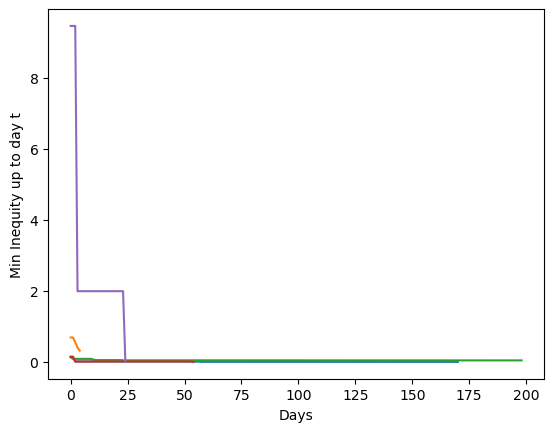

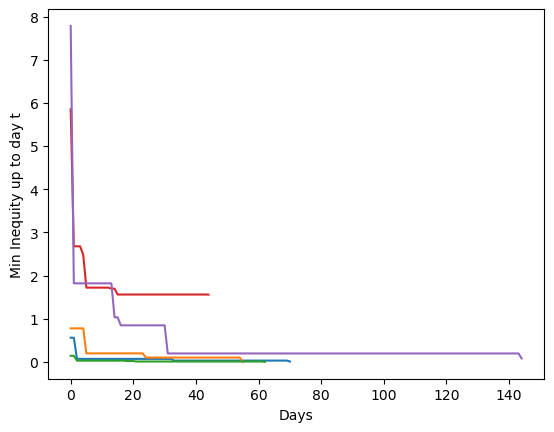

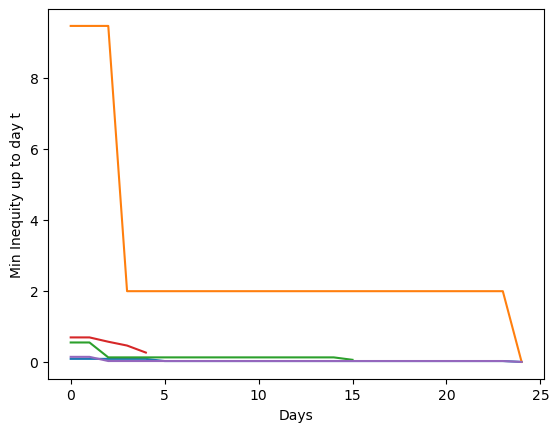

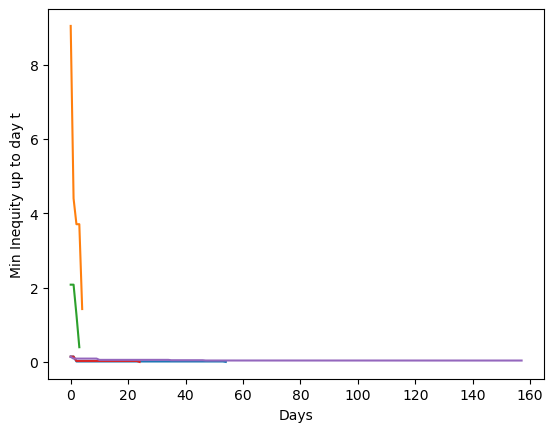

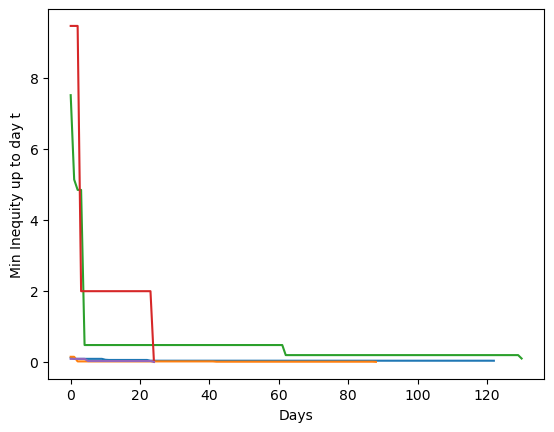

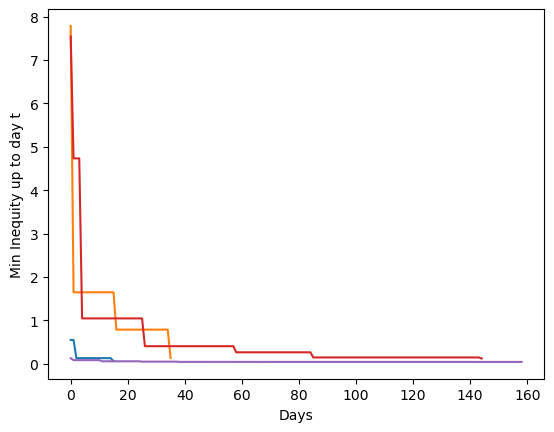

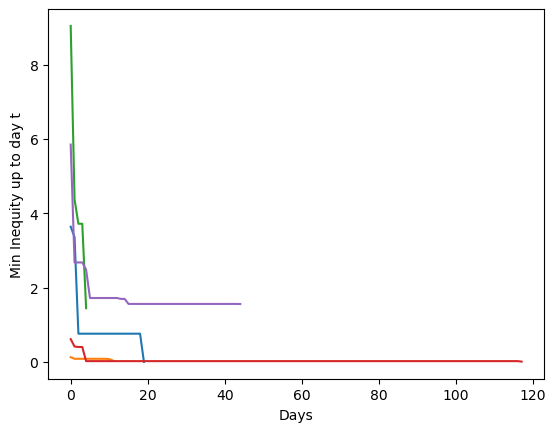

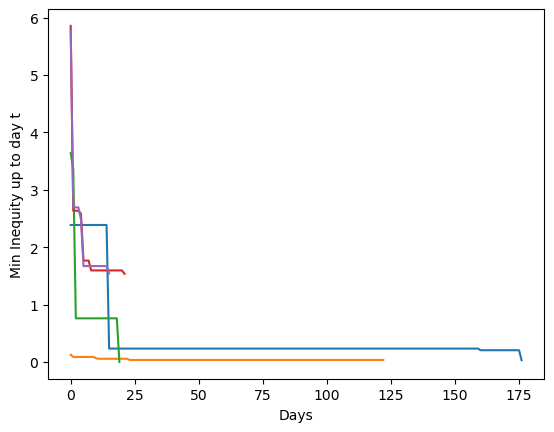

In [144]:
# pick 5 random pairs and plot their inequity
# stop plotting each pair after it reaches minimum inequity

# pick 5 random pairs
df["min_ineq_up_to_t"] = df["inequity"].apply(lambda x: [min(x[:i+1]) for i in range(len(x))])
for i in range(10):
    random_pairs = df[df["convergence"] < 100].sample(5)

    plt.figure()
    for index, row in random_pairs.iterrows():
        min_inequity = row["min_inequity"]
        
        inequity = row["min_ineq_up_to_t"]
        min_idx = np.argmin(inequity)
        inequity = inequity[:min_idx+1]
        plt.plot(inequity)
    # print(random_pairs["OD"])
    plt.xlabel("Days")
    plt.ylabel("Min Inequity up to day t")
    plt.plot()
    

In [145]:
# # plot average inequity for non-converging cycles with tolerance
# avg_inequity = np.mean(df3['inequity_norm'].to_list(), axis=0)
# avg_inequity_all = np.mean(df['inequity_norm'].to_list(), axis=0)

# plt.figure()
# plt.plot(avg_inequity)
# plt.plot(avg_inequity_all)
# plt.ylim(ymin=0)
# plt.xlabel("Days")
# plt.ylabel("Inequity")
# plt.title("Average normalized inequity on non-converging OD pairs over time")
# plt.show()

<Figure size 640x480 with 0 Axes>

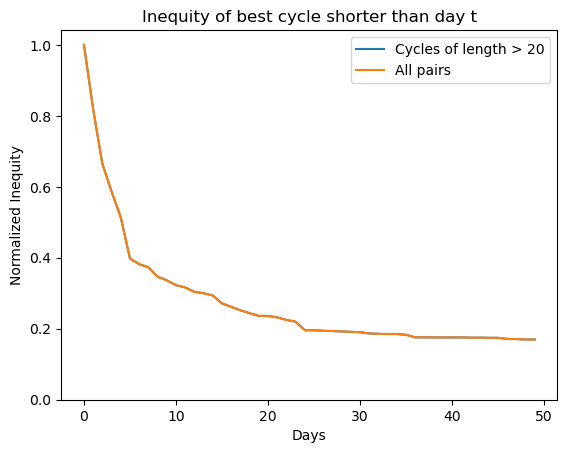

In [146]:
# for each day, calculate minimal inequity up to that day
df4["min_inequity_norm"] = df4["inequity_norm"].apply(lambda x: [min(x[:i+1]) for i in range(len(x))])

df["min_inequity_norm"] = df["inequity_norm"].apply(lambda x: [min(x[:i+1]) for i in range(len(x))])
plt.tight_layout()

plt.figure()
# plot only first 50 days
plt.plot(np.mean(df4["min_inequity_norm"].to_list(), axis=0)[:50])
plt.plot(np.mean(df["min_inequity_norm"].to_list(), axis=0)[:50])
plt.ylim(ymin=0)
plt.xlabel("Days")
plt.ylabel("Normalized Inequity")
plt.title("Inequity of best cycle shorter than day t") 
plt.legend(["Cycles of length > 20", "All pairs"])
# CHANGEEEEE (inequity of best cycle shorter than t days)
# plt.rc('font', size=20)
# make the line thicker
plt.savefig('inequity.png', format='png', dpi=600, transparent=True, bbox_inches='tight')

from matplotlib.pyplot import savefig


In [147]:
df["diff_min_inequity_10-total"] = df["min_inequity_at_10"] - df["min_inequity"]
df["diff_min_inequity_5-total"] = df["min_inequity_at_5"] - df["min_inequity"]
df["diff_min_inequity_50-total"] = df["min_inequity_at_20"] - df["min_inequity"]
df["diff_inequity_min_starting"] = df["inequity_norm"].apply(lambda x: x[0] - min(x))

print("Difference in min inequity at 10 days and total min inequity: ", df["diff_min_inequity_10-total"].mean())
print("Difference in min inequity at 5 days and total min inequity: ", df["diff_min_inequity_5-total"].mean())
for alpha in [0.5,0.2,0.1,0.01,0.001]:
    print("Alpha: ", alpha)
    print("Number of cases where min inequity at 5 days is smaller than alpha: ", (df["min_inequity_at_5"] < alpha).sum())
    print("Number of cases where min inequity at 10 days is smaller than alpha: ", (df["min_inequity_at_10"] < alpha).sum())
    print("Number of cases where min inequity at 50 days is smaller than alpha: ", (df["min_inequity_at_20"] < alpha).sum())

Difference in min inequity at 10 days and total min inequity:  0.21940945569102763
Difference in min inequity at 5 days and total min inequity:  0.3968873723635726
Alpha:  0.5
Number of cases where min inequity at 5 days is smaller than alpha:  112
Number of cases where min inequity at 10 days is smaller than alpha:  151
Number of cases where min inequity at 50 days is smaller than alpha:  175
Alpha:  0.2
Number of cases where min inequity at 5 days is smaller than alpha:  44
Number of cases where min inequity at 10 days is smaller than alpha:  62
Number of cases where min inequity at 50 days is smaller than alpha:  103
Alpha:  0.1
Number of cases where min inequity at 5 days is smaller than alpha:  17
Number of cases where min inequity at 10 days is smaller than alpha:  20
Number of cases where min inequity at 50 days is smaller than alpha:  42
Alpha:  0.01
Number of cases where min inequity at 5 days is smaller than alpha:  3
Number of cases where min inequity at 10 days is smaller t

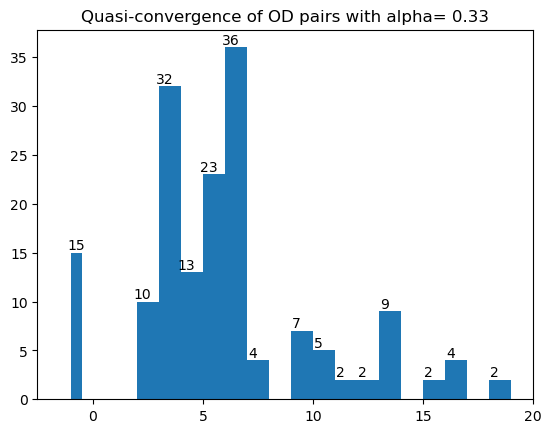

/var/folders/w4/xs9m4t1j28598sp65xft3k1h0000gn/T/ipykernel_85423/2115657430.py:23: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  plt.plot(cdf[:20])


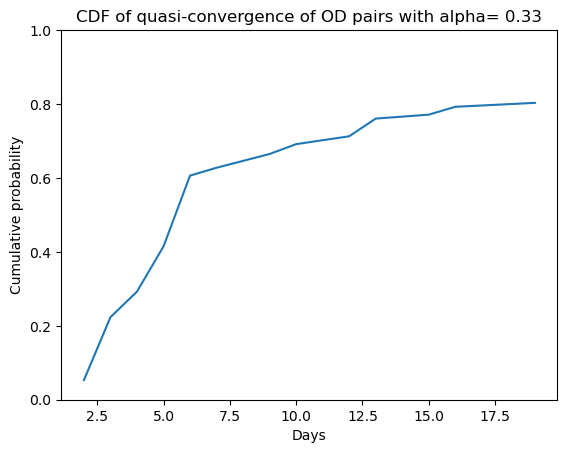

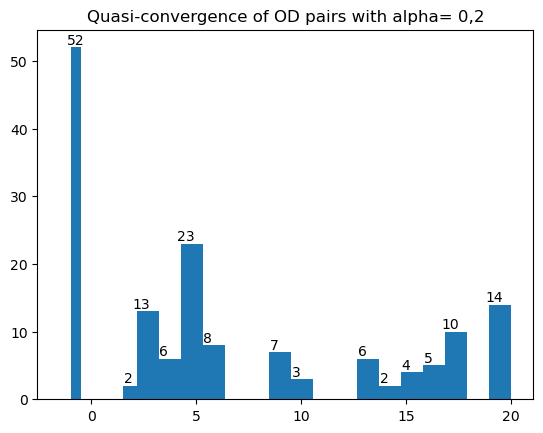

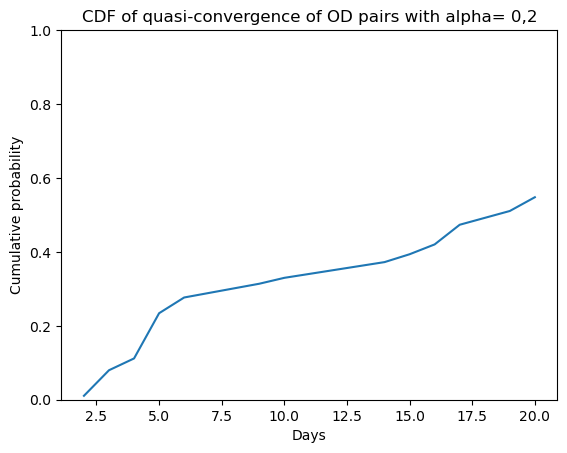

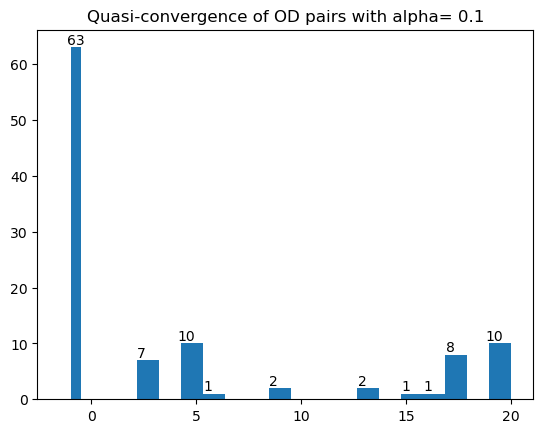

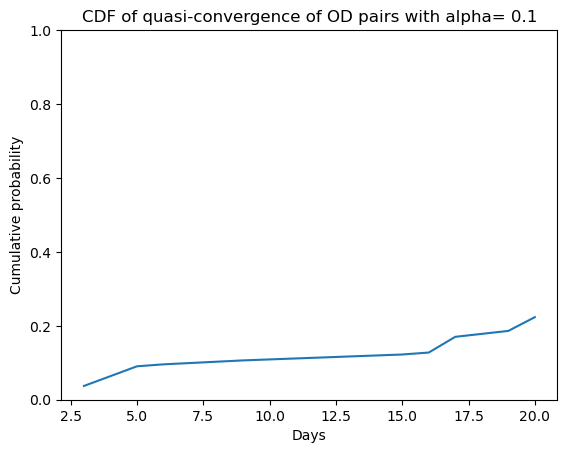

In [148]:
# analysis of almost convergence for non-converging cycles
param = ["0.33", "0,2", "0.1"]
for i in range(almost_conv_params): # for each almost convergence parameter
    # plot histogram of almost convergence
    data = df["almost_convergence_" + str(i)][df["almost_convergence_" + str(i)] <= 20]
    bin_edges = np.histogram_bin_edges(data, bins=20)
    bin_edges = np.unique(np.concatenate((bin_edges, [-1.5, -0.5, 0.5, 1.5])))
    
    plt.figure()
    plt.title("Quasi-convergence of OD pairs with alpha= " + param[i])
    counts, bins, patches = plt.hist(data, bins=bin_edges)
    for count, bin in zip(counts, bins):
        if count > 0:
            plt.text(bin + (bins[1] - bins[0]) / 2, count, str(int(count)),
                     ha='center', va='bottom', fontsize=10, color='black')
    plt.show()
    # create a cdf with the same data
    data = df["almost_convergence_" + str(i)]
    data = data.apply(lambda x: x if x  > 0 else 1e5)
    plt.figure()
    cdf = np.cumsum(data.value_counts(normalize=True).sort_index())
    #plot first 20 values
    plt.plot(cdf[:20])
    plt.xlabel("Days")
    plt.ylabel("Cumulative probability")
    plt.ylim(0,1)
    # plt.xticks(np.arange(xmin, xmax, 3))
    plt.title("CDF of quasi-convergence of OD pairs with alpha= " + param[i])
    plt.show()
    

In [149]:
# stats analysis for greedy cycles
# max, mean, median, 75th percentile, 95th percentile, std of the min inequity
print("Max min inequity: ", df["min_inequity"].max())
print("Mean min inequity: ", df["min_inequity"].mean())
print("Median min inequity: ", df["min_inequity"].median())
print("75th percentile min inequity: ", df["min_inequity"].quantile(0.75))
print("95th percentile min inequity: ", df["min_inequity"].quantile(0.95))
print("std min inequity: ", df["min_inequity"].std())

# at 5 days
print("Max min inequity at 5 days: ", df["min_inequity_at_5"].max())
print("Mean min inequity at 5 days: ", df["min_inequity_at_5"].mean())
print("Median min inequity at 5 days: ", df["min_inequity_at_5"].median())
print("75th percentile min inequity at 5 days: ", df["min_inequity_at_5"].quantile(0.75))
print("95th percentile min inequity at 5 days: ", df["min_inequity_at_5"].quantile(0.95))
print("std min inequity at 5 days: ", df["min_inequity_at_5"].std())

# at 10 days
print("Max min inequity at 10 days: ", df["min_inequity_at_10"].max())
print("Mean min inequity at 10 days: ", df["min_inequity_at_10"].mean())
print("Median min inequity at 10 days: ", df["min_inequity_at_10"].median())
print("75th percentile min inequity at 10 days: ", df["min_inequity_at_10"].quantile(0.75))
print("95th percentile min inequity at 10 days: ", df["min_inequity_at_10"].quantile(0.95))
print("std min inequity at 10 days: ", df["min_inequity_at_10"].std())

# at 20 days
print("Max min inequity at 20 days: ", df["min_inequity_at_20"].max())
print("Mean min inequity at 20 days: ", df["min_inequity_at_20"].mean())
print("Median min inequity at 20 days: ", df["min_inequity_at_20"].median())
print("75th percentile min inequity at 20 days: ", df["min_inequity_at_20"].quantile(0.75))
print("95th percentile min inequity at 20 days: ", df["min_inequity_at_20"].quantile(0.95))
print("std min inequity at 20 days: ", df["min_inequity_at_20"].std())


Max min inequity:  1.0
Mean min inequity:  0.11721609047903922
Median min inequity:  0.012878625798936214
75th percentile min inequity:  0.25240834954154734
95th percentile min inequity:  0.4472709232393674
std min inequity:  0.19078089632869819
Max min inequity at 5 days:  1.0
Mean min inequity at 5 days:  0.5141034628426118
Median min inequity at 5 days:  0.42063262144282854
75th percentile min inequity at 5 days:  1.0
95th percentile min inequity at 5 days:  1.0
std min inequity at 5 days:  0.3567372336069651
Max min inequity at 10 days:  1.0
Mean min inequity at 10 days:  0.33662554617006696
Median min inequity at 10 days:  0.2619732379174742
75th percentile min inequity at 10 days:  0.39840055469533736
95th percentile min inequity at 10 days:  1.0
std min inequity at 10 days:  0.27129313328539945
Max min inequity at 20 days:  1.0
Mean min inequity at 20 days:  0.23618018297963153
Median min inequity at 20 days:  0.17483519985122917
75th percentile min inequity at 20 days:  0.28571

In [150]:
#find OD pair that has min_inequilty 1
print(df[df["min_inequity"] == 1.0])

      convergence difference    UE_time  \
11 9           -1   0.301666  17.920238   
9  11          -1   0.401662  18.080255   
6  17          -1   2.543276  34.910876   

                                                    mean  \
11 9   [17.61857142857143, 35.23714285714286, 52.8557...   
9  11  [17.67859285714286, 35.35718571428572, 53.0357...   
6  17  [32.3676, 64.73519999999999, 97.1028, 129.4704...   

                                                variance  \
11 9   [0.03421224489795919, 0.06827755102040817, 0.1...   
9  11  [0.034383519948979556, 0.06861936551020402, 0....   
6  17  [3.440394239999997, 5.9074969599999925, 7.4013...   

                                                 history agents  \
11 9   [[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...   1400   
9  11  [[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...   1400   
6  17  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...    500   

                                                inequity almost_convergence 